In [1]:
import torch

from src.datasets import DiffLinkerDataModule, collate  # 路径按你项目实际情况调整
from src import const

# ===== 手动配置参数 =====
data_path = "/home/qianyouqiao/pdbbind_processed_3"          # 这里改成你的数据目录
train_prefix = 'pdbbind_train.full'     # 或者 "zinc_train" 等
val_prefix = 'pdbbind_val.full'
test_prefix = None

batch_size = 8        # 调试建议设小一点
dataset_device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 0       # Notebook 调试建议设为 0，避免多进程问题


In [2]:
datamodule = DiffLinkerDataModule(
    data_path=data_path,
    train_data_prefix=train_prefix,
    val_data_prefix=val_prefix,
    test_data_prefix=test_prefix,
    batch_size=batch_size,
    dataset_device=dataset_device,
    collate_fn=collate,          # 使用你在 dataset.py 中定义的 collate
    train_shuffle=False,         # 调试阶段关闭 shuffle 便于复现
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=False,
    prefetch_factor=None,
    is_demo=False,
)

# 这里只演示从 train_dataloader 取数据，如需 val/test 可自行改成相应的 setup 和 dataloader
datamodule.setup(stage="validate")
# train_loader = datamodule.train_dataloader()
val_loader = iter(datamodule.val_dataloader())

def print_batch(batch):
    print("Batch keys and shapes:")
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            print(f"{k:20s}: shape={tuple(v.shape)}, dtype={v.dtype}, device={v.device}")
        else:
            print(f"{k:20s}: type={type(v)}")

start processing data
start loading data


/home/qianyouqiao/DiffLinker/src/datasets.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(dataset_path, map_location=device)


finish loading data


In [3]:
val_loader = iter(datamodule.val_dataloader())

In [4]:
batch = next(val_loader)  # 取出第一个 batch
print_batch(batch)

Batch keys and shapes:
uuid                : type=<class 'list'>
name                : type=<class 'list'>
positions           : shape=(8, 650, 3), dtype=torch.float32, device=cuda:0
one_hot             : shape=(8, 650, 9), dtype=torch.float32, device=cuda:0
charges             : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
anchors             : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
fragment_only_mask  : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
pocket_mask         : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
fragment_mask       : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
linker_mask         : shape=(8, 650, 1), dtype=torch.float32, device=cuda:0
num_atoms           : type=<class 'list'>
atom_mask           : shape=(8, 650, 1), dtype=torch.int8, device=cuda:0
edge_mask           : shape=(5200,), dtype=torch.int8, device=cuda:0


In [39]:
from src.molecule_builder import build_molecule, build_molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True       # 关键：这里再开一次原子编号

def is_valid(mol):
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        return False
    return True

pocket = batch['pocket_mask'].bool()
atom_mask = (batch['atom_mask'].bool() & (~pocket)).to(batch['atom_mask'].dtype)

true_molecules_batch = build_molecules(
    batch['one_hot'],
    batch['positions'],
    atom_mask,
    is_geom=False,
)

In [ ]:
smi = batch['name'][0]
true_mol = Chem.MolFromSmiles(smi)
builded_mol = true_molecules_batch[0]

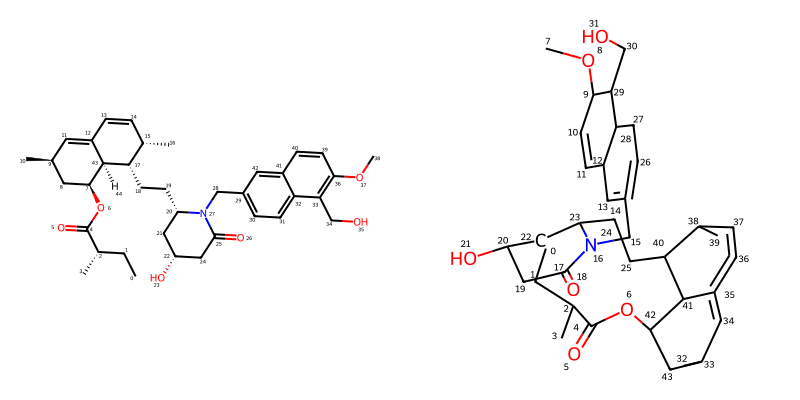

In [43]:
Draw.MolsToImage((true_mol, builded_mol), subImgSize=(400,400), options=opts)

In [64]:
def get_atomic_num(one_hot, positions, node_mask, is_geom=True):
    if is_geom:
        IDX2ATOMICNUM = {0: 6, 1: 8, 2: 7, 3: 9, 4: 16, 5: 17, 6: 35, 7: 53, 8: 15}
    molecules = []
    for i in range(len(one_hot)):
        mask = node_mask[i].squeeze() == 1
        atom_types = one_hot[i][mask].argmax(dim=1).detach().cpu()
        atom_positions = positions[i][mask].detach().cpu().numpy()

        mol = []
        for a, (x,y,z) in zip(atom_types, atom_positions):
            return (x,y,z)
            mol.append((IDX2ATOMICNUM[a.item()], x)) 
        molecules.append(mol)
    return molecules

pocket = batch['pocket_mask'].bool()
atom_mask = (batch['atom_mask'].bool() & (~pocket)).to(batch['atom_mask'].dtype)
t = get_atomic_num(batch['one_hot'], batch['positions'], atom_mask)
t

(np.float32(28.241), np.float32(88.781), np.float32(38.491))

In [9]:
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
opts = Draw.MolDrawOptions()
opts.addAtomIndices = True       # 关键：这里再开一次原子编号

In [ ]:
gen_smi_file = 'formatted/epoch_385/pdbbind_test.full.smi'

data = []
with open(gen_smi_file, 'r') as f:
    for line in tqdm(f.readlines()):
        parts = line.strip().split(' ')
        data.append({
            'fragments': parts[0],
            'true_molecule': parts[1],
            'pred_molecule': parts[2],
            'pred_linker': parts[3] if len(parts) > 3 else '',
        })

100%|██████████| 3580/3580 [00:00<00:00, 829912.58it/s]


In [42]:
def neutralize_charges(mol):
    patterns = (
        ('[n+;H]', 'n'), 
        ('[N+;!H0]', 'N'),
        ('[$([O-]);!$([O-][#7])]', 'O'),
        ('[S-]', 'S'),
        ('[$([N-]);!$([N-][#6]=O)]', 'N'),
    )
    replaced = False
    for patt, rep in patterns:
        while mol.HasSubstructMatch(Chem.MolFromSmarts(patt)):
            rms = Chem.ReplaceSubstructs(mol, Chem.MolFromSmarts(patt),
                                         Chem.MolFromSmarts(rep), replaceAll=False)
            mol = rms[0]
            replaced = True
    if replaced:
        Chem.SanitizeMol(mol)
    return mol

def is_valid(pred_mol_smiles, frag_smiles, if_neutralize=True):
    pred_mol = Chem.MolFromSmiles(pred_mol_smiles)
    frag = Chem.MolFromSmiles(frag_smiles)
    if frag is None:
        return False
    if pred_mol is None:
        return False
    try:
        Chem.SanitizeMol(pred_mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_PROPERTIES)
    except Exception:
        return False
    if if_neutralize:
        frag = neutralize_charges(frag)
        pred_mol = neutralize_charges(pred_mol)
    if len(pred_mol.GetSubstructMatch(frag)) != frag.GetNumAtoms():
        return False
    return True


In [43]:
valid_cnt = 0
total_cnt = 0

for i, obj in tqdm(enumerate(data)):
    valid = is_valid(obj['pred_molecule'], obj['fragments'])
    obj['valid'] = valid
    valid_cnt += valid
    total_cnt += 1

validity = valid_cnt / total_cnt * 100
print(f'Validity: {validity:.3f}%')

0it [00:00, ?it/s][17:23:03] Explicit valence for atom # 12 N, 4, is greater than permitted
74it [00:00, 736.56it/s][17:23:03] Explicit valence for atom # 14 N, 4, is greater than permitted
[17:23:03] Explicit valence for atom # 4 N, 4, is greater than permitted
219it [00:00, 1145.86it/s][17:23:03] Explicit valence for atom # 8 N, 4, is greater than permitted
[17:23:03] Explicit valence for atom # 19 N, 4, is greater than permitted
[17:23:03] Explicit valence for atom # 9 N, 4, is greater than permitted
[17:23:03] Explicit valence for atom # 11 C, 5, is greater than permitted
364it [00:00, 1281.51it/s][17:23:03] Explicit valence for atom # 7 N, 4, is greater than permitted
502it [00:00, 1320.10it/s][17:23:03] Explicit valence for atom # 7 N, 4, is greater than permitted
[17:23:03] Explicit valence for atom # 11 N, 4, is greater than permitted
[17:23:03] Explicit valence for atom # 21 N, 4, is greater than permitted
658it [00:00, 1406.34it/s][17:23:03] Explicit valence for atom # 14 C, 

Validity: 80.112%


In [49]:
df = pd.DataFrame(data)
error_list = df[df['valid']==False]
error_list

,fragments,true_molecule,pred_molecule,pred_linker,valid
4,CC[C@H](O)CO.CN1CC[NH+](C)CC1,C[NH+]1CCN(CCCNC(=O)c2c(-c3ccccc3)c(-c3ccc(Cl)...,CC[C@@](O)(F)CCC(N)C(=O)NC(C)CCN1CCN(C)CC1,,False
21,CCN(C=O)CC.c1ccsc1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN(CO)C(C)N1C(CCC2=COC(C)=C2)[C@]1(O)C1=CC=CS1,,False
36,C1CCCCC1.C[NH2+][C@@H](C)C(N)=O,C[NH2+][C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1c1...,CC(NCOCC(O)C(O)CC=N)C(N)=O,,False
40,CC(=O)N1CC[NH+](C)CC1.c1ccccc1,CC(=O)C1[N-][N@H+]2c3cc(F)ccc3OC[C@H]2[C@@]1(C...,CC1CCOC2=C1C1=C(C=CC2)[N@@]2(CC1)C(C/N=C\N1CCN...,,False
53,CCN(C=O)CC.c1ccsc1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN(CO)C(C)C(CC1=CC=CS1)NC(=O)CC1=CC=CC=C1,,False
...,...,...,...,...,...
3568,CC1=NCCCC1.COC(=O)N1CC[NH+](C[C@H]2CCC[C@H]([N...,COC(=O)N1CC[NH+](C[C@H]2CCC[C@H]([NH2+][C@H](O...,COC(=O)N1CCN(CC2C=CCC(NC(=O)NC3=CC=C(C)N=C3)C2...,,False
3569,CC1=NCCCC1.COC(=O)N1CC[NH+](C[C@H]2CCC[C@H]([N...,COC(=O)N1CC[NH+](C[C@H]2CCC[C@H]([NH2+][C@H](O...,COC(=O)N1CCN(CC2C=CCC(NC(=O)NC3=CC=C(C)N=C3)C2...,,False
3570,C[NH2+][C@@H](C)C(N)=O.c1ccccc1,C[NH2+][C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1c1...,CNC(C)C(=O)NC(CNCO)C(=O)N1C[C@]1(C)O,,False
3571,C[NH2+][C@@H](C)C(N)=O.c1ccccc1,C[NH2+][C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1c1...,OC(=O)CCC(=O)OC(=O)NCCNC(=O)C1=CC=CC=C1,,False


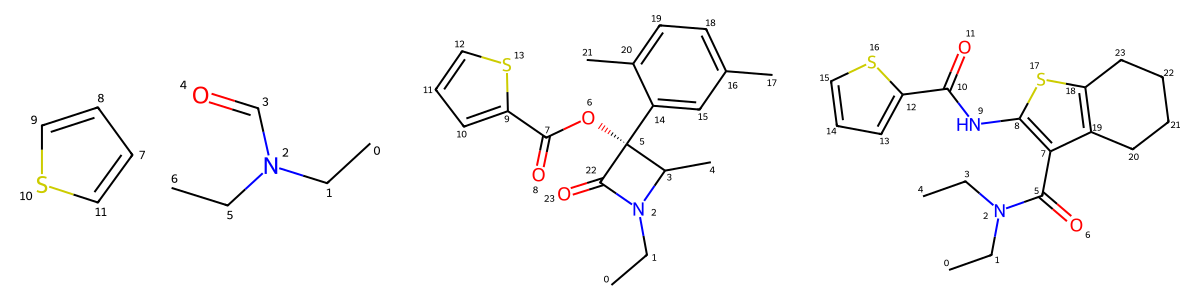

In [52]:
frag = Chem.MolFromSmiles(df['fragments'][20])
pred_mol = Chem.MolFromSmiles(df['pred_molecule'][20])
true_mol = Chem.MolFromSmiles(df['true_molecule'][20])
Draw.MolsToImage([frag, pred_mol, true_mol], subImgSize=(400,300), options=opts)

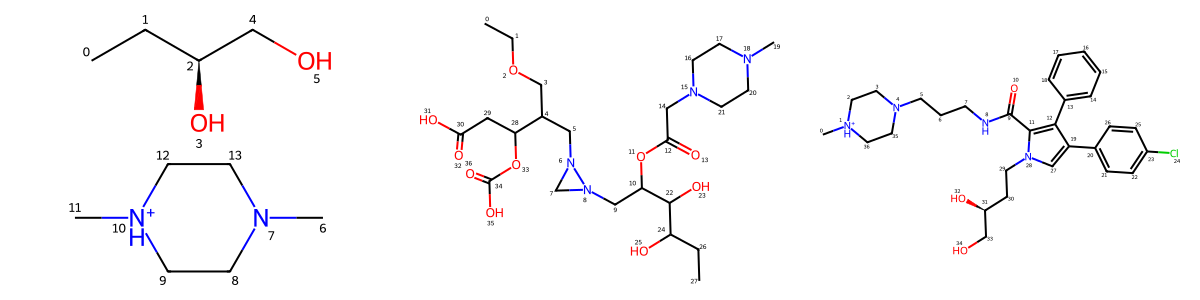

In [31]:
df = pd.DataFrame(data)
smi = df['pred_molecule'][0]
frag = Chem.MolFromSmiles(df['fragments'][0])
pred_mol = Chem.MolFromSmiles(df['pred_molecule'][0])
true_mol = Chem.MolFromSmiles(df['true_molecule'][0])
Draw.MolsToImage([frag, pred_mol, true_mol], subImgSize=(400,300), options=opts)

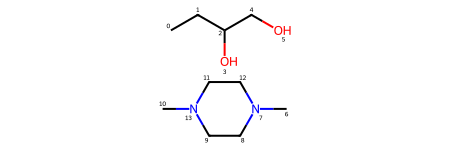

In [40]:
frag = neutralize_charges(frag)
frag

In [41]:
Chem.SanitizeMol(pred_mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_PROPERTIES)
pred_mol.GetSubstructMatch(frag)


(9, 10, 22, 23, 24, 25, 14, 15, 16, 17, 19, 20, 21, 18)

In [20]:
df[df['valid']==True]

,fragments,true_molecule,pred_molecule,pred_linker,valid
20,CCN(C=O)CC.c1ccsc1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN1C(C)[C@](OC(=O)C2=CC=CS2)(C2=CC(C)=CC=C2C)...,,True
22,CCN(C=O)CC.c1ccsc1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN(CC)C(=O)NC1=C(CNC(C=O)C2=CC=CS2)C=CC=C1,,True
23,CCN(C=O)CC.c1ccsc1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN(CC)C(=O)NC1=C(C(F)CC(=O)C2=CC=CS2)C=CC=C1,,True
24,CCN(C=O)CC.c1ccsc1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN(CC)C(=O)C(NC(=O)C(C)(C)C)C(=O)SCC1=CC=CS1,,True
25,CCN(C=O)CC.c1ccsc1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN(CC)C(=O)NC(CC1=CC=CC=C1)NC(=O)C1=CC=CS1,,True
...,...,...,...,...,...
3553,CCN(C=O)CC.O=Cc1cccs1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN1C(C)[C@](NC(=O)C2=CC=CS2)(C2=CC(=O)C(C)CN2...,,True
3554,CCN(C=O)CC.O=Cc1cccs1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN1C(C)C(C(CC2=CC=CC=C2)NC(=O)C2=CC=CS2)C1=O,,True
3555,CCN(C=O)CC.O=Cc1cccs1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN1C(C)C(C(CNC(=O)C2=CC=CS2)C2=CC=CC=C2)C1=O,,True
3556,CCN(C=O)CC.O=Cc1cccs1,CCN(CC)C(=O)c1c(NC(=O)c2cccs2)sc2c1CCCC2,CCN1C(C)[C@]2(C(CC3=CC=CC=C3)N2C(=O)C2=CC=CS2)...,,True
